# Mathematical model of antibiotic resistance N. gonorrhoeae spread

### Transmission model
* $Sen$ and $Res$ indicate the antibitotic-sensitive and -resistand N. gonorrhoeae strains
* $G = \{L,H\}$ is the set of low and high sexual activity groups, $i \in G$
* Each sexual activity group $N_i$ consists of:
    * susceptible hosts $S_i$
    * hosts infected with an antibiotic-sensitive strain, $I_{Sen_i}$
    * hosts infected with an antibiotic-resistant strain, $I_{Res_i}$
* Hosts are redistributed to either the same of the other sexual activity group at rate $\gamma$
* Hosts leave or enter the population at rate $\alpha$
* Susceptible hosts become infected depending on:
    * the partner change rate, $\pi_i$
    * the transmission probability per partnership, $\beta_{ij}$
    * the sexual mixing matrix $\rho_{ij}$ 
* Hosts infected with an antibiotic-sensitive strain can:
    * recover spontaneously at rate $\nu$
    * receive treatment at rate $\tau$
* Hosts receiving treatment recover at rate $\tau(1 - \mu)$
* Hosts decelop resistance during treatment with probability $\mu$
* Host infected with an antibiotic-resistance strain can only recover spontaneously at rate $\nu$
    
The sexual mixing matrix describes how many partnerships are formed within and outside the host's activity group:

$$ \rho_{ij} = \epsilon \delta_{ij} + (1 - \epsilon) \frac{\pi_j N_j}{\sum_{k \in G} \pi_k N_k} $$

Here, $\delta_{ij} = 1$ if $i = j$ and 0 otherwise. Model parameters were estimated from sexual behavior data, calibrated trough model simulation or informed by literature. The parameters can be found on page 5 of the article

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint

%matplotlib notebook

### Differential equations

In [3]:
# sexual mixing matrix
def SMM(i, j, N, epsilon, pi):
    return epsilon * (i == j) + (1 - epsilon) * pi[j] * N[j] / np.sum(pi * N)

# change in susceptible hosts in group i
def dSidt(S, Ires, Isen, N, pi, i, alpha, beta, gamma, epsilon, phi, mu, D):
    nu = (1 - phi) / D
    tau = phi / D

    dSi = -S[i] * pi[i] * sum([
        SMM(i, j, N, epsilon, pi) * beta[i, j] * (Isen[j] + Ires[j]) / N[j]
        for j in [0, 1]
    ]) + nu * (Isen[i] + Ires[i]) + tau * (1 - mu) * Isen[i] + alpha * (
        -S[i] + N[i]) - gamma * S[i] + gamma * N[i] * sum(S)

    return dSi

# change in infecteds of sensitive strain in group i
def dIsenidt(S, Ires, Isen, N, pi, i, alpha, beta, gamma, epsilon, phi, mu, D):
    nu = (1 - phi) / D
    tau = phi / D

    dIseni = S[i] * pi[i] * sum([
        SMM(i, j, N, epsilon, pi) * beta[i, j] * Isen[j] / N[j]
        for j in [0, 1]
    ]) - (nu + tau + alpha + gamma) * Isen[i] + gamma * N[i] * np.sum(Isen)
    
    return dIseni

# change in infecteds of resistant strain in group i
def dIresidt(S, Ires, Isen, N, pi, i, alpha, beta, gamma, epsilon, phi, mu, D):
    nu = (1 - phi) / D
    tau = phi / D

    dIresi = S[i] * pi[i] * sum([
        SMM(i, j, N, epsilon, pi) * beta[i, j] * Ires[j] / N[j]
        for j in [0, 1]
    ]) - (nu + alpha + gamma) * Ires[i] + tau * mu * Isen[i] + gamma * N[i] * np.sum(Ires)
    return dIresi

# full model
def model(y, t, N, pi, alpha, beta, gamma, epsilon, phi, mu, D):
    dydt = []
    S = y[:2]
    Ires = y[2:4]
    Isen = y[4:]

    funcs = [dSidt, dIresidt, dIsenidt]

    for func in funcs:
        for i in range(2):
            dydt.append(
                func(S, Ires, Isen, N, pi, i, alpha, beta, gamma, epsilon, phi,
                     mu, D))
    return dydt

### MSM Parameters

In [4]:
Nh = 5.3e-2
N = np.array([1 - Nh, Nh])

S = np.array([N[0]*0.995,N[1]*0.90])
Ires = np.array([0, 0])
Isen = np.array([N[0]*0.005, N[1]*0.1])

pi = np.array([0.41, 30.49])


BLL = np.array([0.42,0.59,0.77])
BHH = np.array([0.25,0.30,0.40])
alpha = 1 / 29


gamma = 1
epsilon = np.array([0.30,0.57,0.80])
phi = np.array([0.48,0.64,0.81])
mu = 1e-3
D = np.array([0.14,0.19,0.25])

y0 = np.concatenate((S, Ires, Isen))
# y0 /= np.sum(y0)
t = np.arange(0,30,0.001)
sol_msm = []
for i in range(3):
    beta = np.array([[BLL[i], 1], [1, BHH[i]]])
    beta[0, 1] = beta[1, 0] = np.sqrt(beta[0, 0] * beta[1, 1])
    sol_msm.append(odeint(model, y0, t, args=(N, pi, alpha, beta, gamma, epsilon[i], phi[i], mu, D[i])))
    
sol_msm = np.array(sol_msm)

### HMW Parameters

In [5]:
Nh = 6.3e-2
N = np.array([1 - Nh, Nh])

S = np.array([N[0]*0.995,N[1]*0.90])
Ires = np.array([0, 0])
Isen = np.array([N[0]*0.005, N[1]*0.1])

pi = np.array([0.25, 4.57])


alpha = 1 / 29
BLL = np.array([0.79,0.87,0.94])
BHH = np.array([0.63,0.72,0.81])

gamma = 1
epsilon = np.array([0.53,0.73,0.89])
phi = np.array([0.36,0.50,0.66])
mu = 1e-3
D = np.array([0.46,0.55,0.66])

y0 = np.concatenate((S, Ires, Isen))
# y0 /= np.sum(y0)
t = np.arange(0,30,0.001)
sol_hmw = []
for i in range(3):
    beta = np.array([[BLL[i], 1], [1, BHH[i]]])
    beta[0, 1] = beta[1, 0] = np.sqrt(beta[0, 0] * beta[1, 1])
    sol_hmw.append(odeint(model, y0, t, args=(N, pi, alpha, beta, gamma, epsilon[i], phi[i], mu, D[i])))
    
sol_hmw = np.array(sol_hmw)

### Figures and plots

<IPython.core.display.Javascript object>


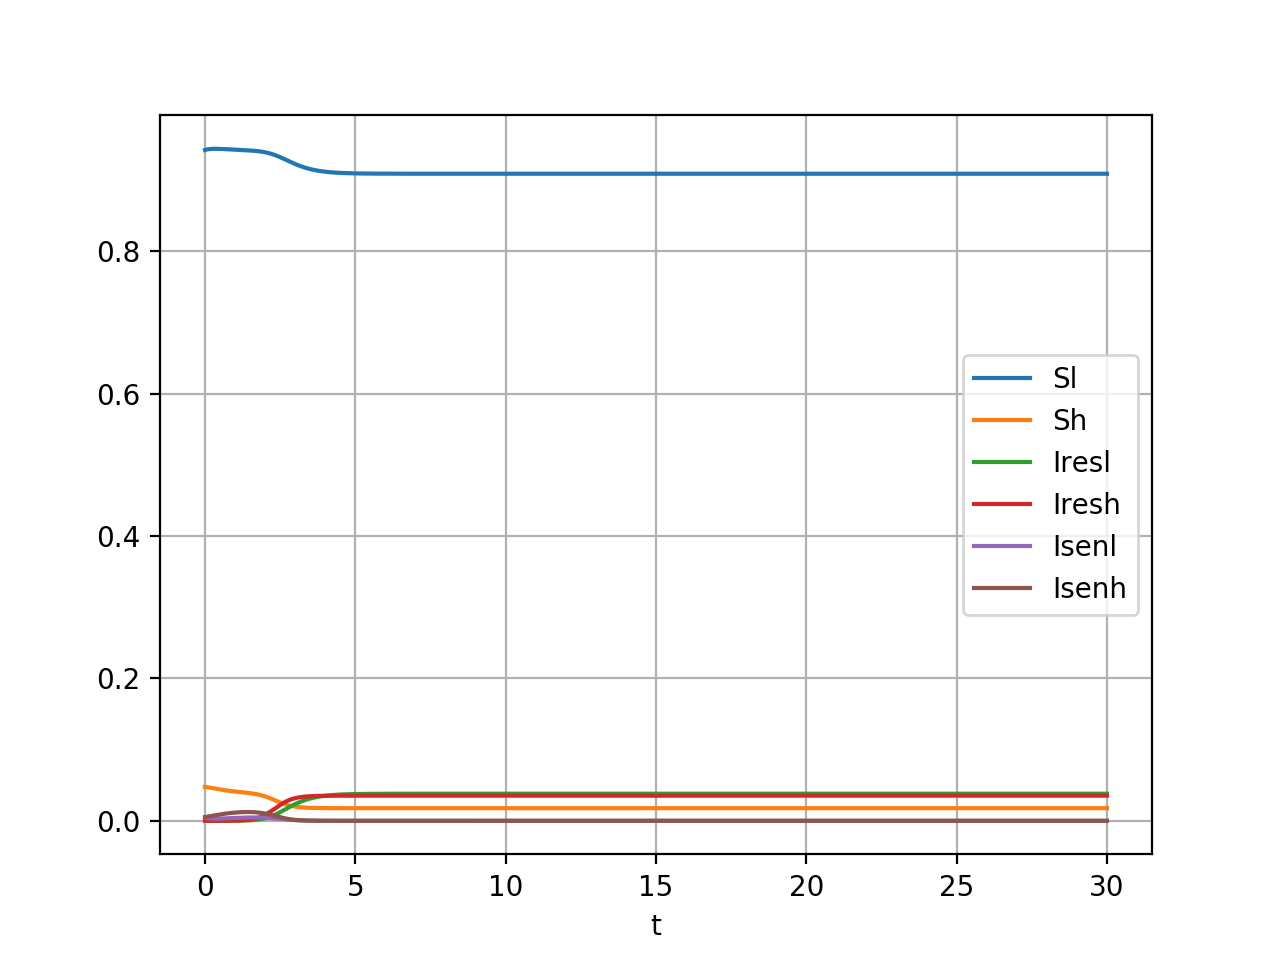

In [6]:
plt.figure()
plt.plot(t, sol_msm[1,:, 0], label='Sl')
plt.plot(t, sol_msm[1,:, 1], label='Sh')
plt.plot(t, sol_msm[1,:, 2], label='Iresl')
plt.plot(t, sol_msm[1,:, 3], label='Iresh')
plt.plot(t, sol_msm[1,:, 4], label='Isenl')
plt.plot(t, sol_msm[1,:, 5], label='Isenh')

plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


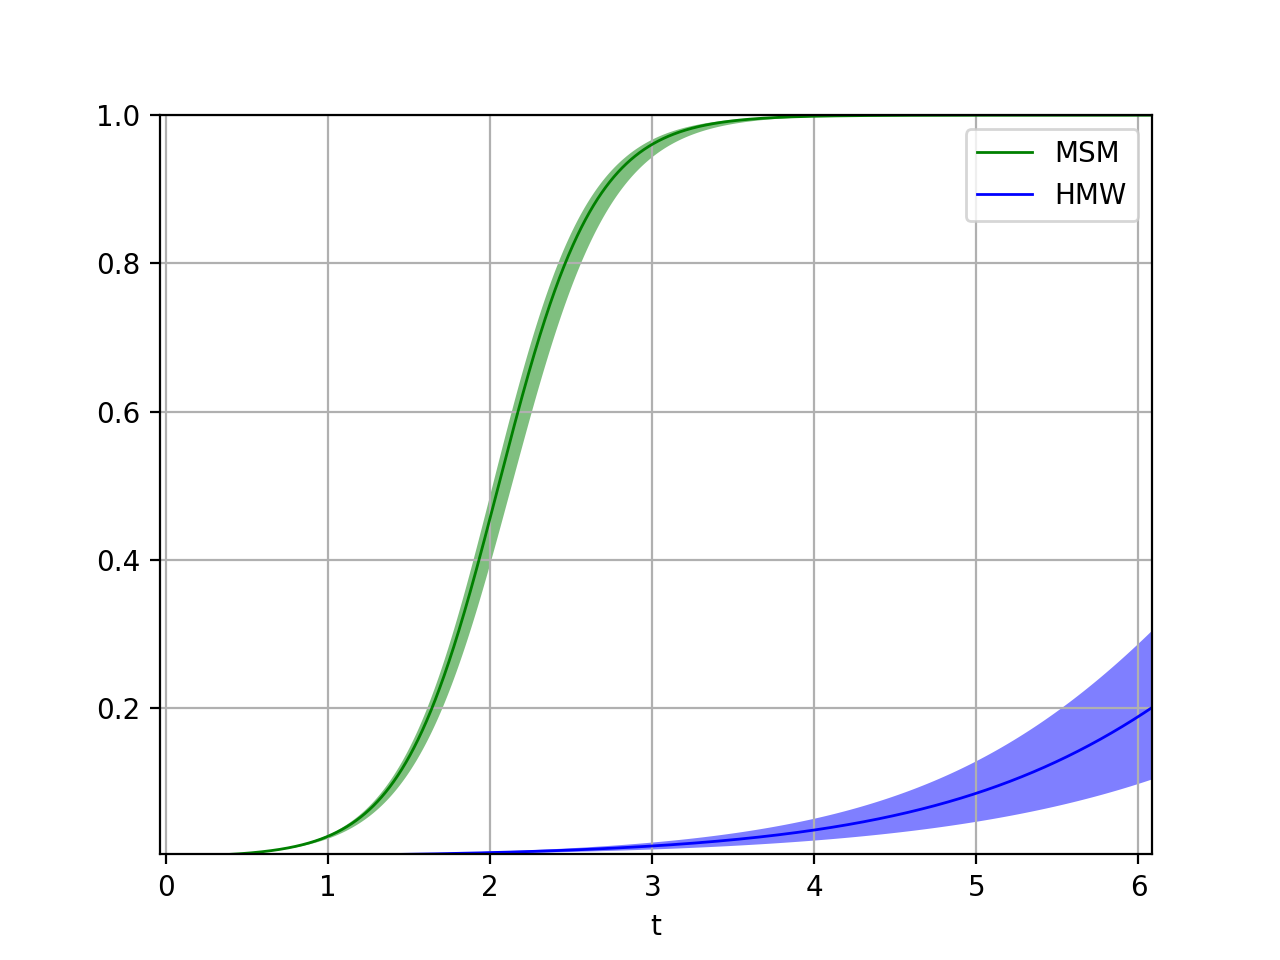

In [7]:
plt.figure()

ratio_sol_msm = (sol_msm[:,:, 2] + sol_msm[:,:, 3])/(sol_msm[:,:, 2] + sol_msm[:,:, 3] + sol_msm[:,:, 4] + sol_msm[:,:, 5])
plt.plot(t, ratio_sol_msm[1,:], label = "MSM", c = "g",linewidth=1)
plt.fill_between(t,ratio_sol_msm[0,:], ratio_sol_msm[2,:], alpha=0.5, facecolor = "g")

ratio_sol_hmw = (sol_hmw[:,:, 2] + sol_hmw[:,:, 3])/(sol_hmw[:,:, 2] + sol_hmw[:,:, 3] + sol_hmw[:,:, 4] + sol_hmw[:,:, 5])
plt.plot(t, ratio_sol_hmw[1,:], label = "HMW", c = "b",linewidth=1)
plt.fill_between(t,ratio_sol_hmw[0,:], ratio_sol_hmw[2,:], alpha=0.5, facecolor = "b")



plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.ylim(0,1)
plt.show()